### MA3402 Estadística
## Tarea 2, Entrega 1: Intervalos de confianza.

**Profesor:** Joaquín Fontbona T.
**Auxiliares:** Javier Maass, Francisco Muñoz y Diego Olguín.

In [ ]:
# Librerías necesarias
if(!require(Hmisc)){
    install.packages("Hmisc")
}

if(!require(ggplot2)){
    install.packages("ggplot2")
}

if(!require(latex2exp)){
    install.packages("latex2exp")
}

library(Hmisc)
library(ggplot2)
library(latex2exp)

Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: ggplot2

Loading required package: latex2exp



En esta tarea la idea es estimar la efectividad de vacunas contra el COVID-19 y además entregar sus respectivos intervalos de confianza. Para ello se tomarán datos reales de estudios realizados por laboratorios para las vacunas BNT162b2, ChAdOx1 y HBO2. En estos se consideran dos grupos de individuos, uno de control o placebo que es inyectado con solución salina sin anticuerpos, mientras que el otro grupo de vacunados recibe la vacuna a comercializar.

Los dos grupos se reparten de manera equitativa y el estudio es realizado en modalidad doble ciego, es decir, ni los individuos de experimento ni los agentes clínicos saben si se inyecta placebo o anticuerpos, por lo que se supone que los resultados finales son independientes del experimento en sí mismo.

*Nota: En lo que sigue se harán ciertas simplificaciones y se considerará, por ejemplo, que la vacuna tiene la misma efectividad contra todas las cepas de la enfermedad y que al mencionar contagios no se hará distinción entre sintomáticos y asintomáticos.*

### 1. Modelo

Denotemos a $T_0$ y $T_1$ la cantidad de individuos en el grupo placebo y de vacunados, respectivamente y $c_0$ y $c_1$ la cantidad de casos confirmados positivos de COVID-19 en el grupo placebo y de vacunados, respectivamente. Se define también por $c = c_0 + c_1$ la cantidad de contagiados totales después del estudio. Entonces suponemos que $c_1 \sim \text{Bin}(c, \pi)$, donde $\pi \in (0,1)$ es un parámetro desconocido.

Se define la proporción de tasa de incidencia o riesgo relativo como 

$$ IRR = \frac{\pi}{r(1-\pi)} $$

Donde $r = T_1/T_0$ es el ratio de grupos de estudio. Y la efectividad de la vacuna se calcula como $VE = 1 - IRR$. Puede utilizar, sin demostrar, que si $(L_\pi, U_\pi)$ es un intervalo de confianza $(1-\alpha)\%$ para $\pi$ entonces el intervalo de confianza $(1-\alpha)\%$ para VE es

$$ \left ( 1- \frac{U_\pi}{r(1-U_\pi)}, \, 1- \frac{L_\pi}{r(1-L_\pi)} \right )$$

**1.1 Sea $g(p) =1- \frac{p}{r(1-p)}$. Sean $X_1, ..., X_n$ i.i.d. Bernoulli de parámetro $p \in (0,1)$. Sabemos que $\overline X_n = \frac{1}{n} \sum_{i=1}^n X_i$ es el MLE de $p$. Utilice el siguiente código que genera 10000 muestras Binomial de tamaño $n=1000$ y parámetro $p=0.4$ y genera un histograma de $\sqrt{n}(g(\overline X_n)-g(p))$. En base a este gráfico, solo responda**

* ¿A qué ley parece conveger $\sqrt{n}(g(\overline X_n)-g(p))$ cuando $n \to \infty$? Para visualizar mejor la distribución límite, además de apoyarse en el gráfico, calcule la media y varianza empíricas. 
* ¿A qué teoremas del curso se puede deber esto?

*Indicación: Para ver numéricamente la varianza puede utilizar la función de R que calcula la varianza muestral, sea sesgada o insesgada, y aplicarla a g_samples. Le puede ser de utilidad que la información de Fisher para una muestra única de una Bernoulli es $I(p) = 1/(p(1-p))$.*

In [ ]:
# Función que dado un DataFrame df y una columna col de este
# Hace un histograma de dicha columna.
# Está pensado para hacer el histograma de sqrt(n)(g(X_n) - g(p))
plot.hist.p1 <- function(df, col) {
    ggplot(df, aes(x=col)) + 
    geom_histogram(aes(y=after_stat(density)) ,bins = 40) +
    geom_vline(aes(xintercept=mean(g_samples)),
            color="blue", linetype="dashed") +
    geom_density(alpha=.2, fill="#FF6666") +
    labs(title=TeX("Muestras normalizadas al aplicar $g$"),x=TeX("$sqrt(n)(g(X_n) - g(p))$"), y = "Densidad") +
    theme(plot.title = element_text(hjust = 0.5))
}

In [ ]:
# Función g, que puede ser de utilidad para los cálculos posteriores
g <- function(p) {
    1 - p/(r*(1-p))
}

r <- 1 # Factor r

n_samples <- 10000 # Cantidad de muestras
size <- 1000 # Tamaño de las binomiales
prob <- 0.4 # Valor p real

# Muestras de binomiales
samples <- rbinom(n=n_samples, size=size, prob=prob)

# Muestras de binomiales reajustadas a su tamaño
resize_samples <- samples/size
# Objeto a estudiar su ley
g_samples <- sqrt(size)*(g(resize_samples) - g(prob))

# DataFrame con los resultados numéricos
df <- data.frame(g_samples)

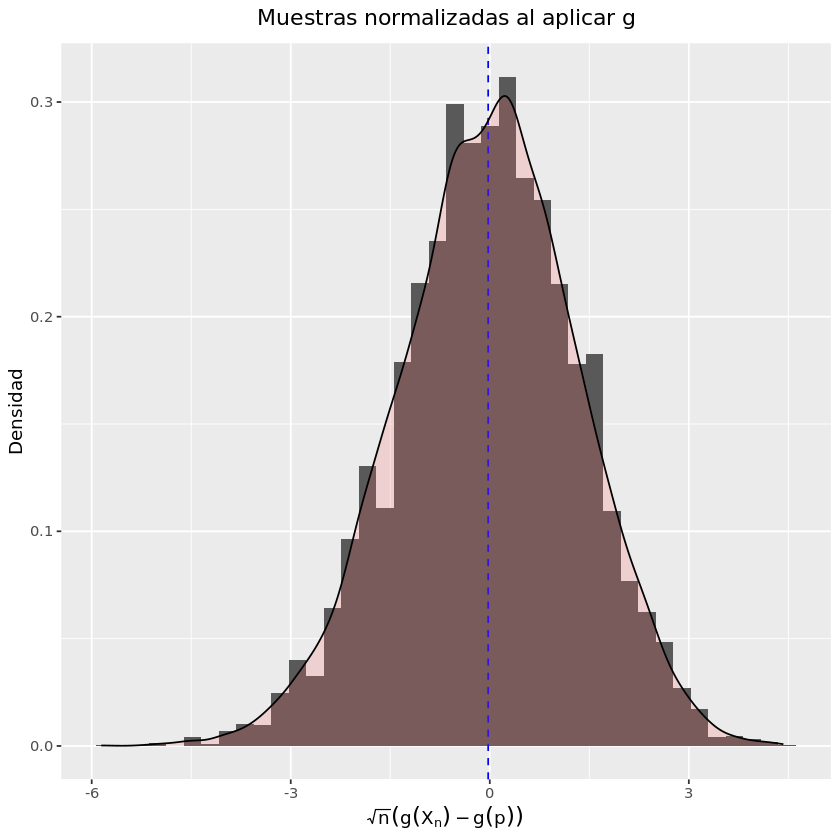

In [ ]:
plot.hist.p1(df, g_samples)

### 2. Intervalo de confianza con aproximación por TCL (asintótico)

En lo que sigue se harán los cálculos para intervalos de confianza para distintos $1-\alpha$ y distintos métodos para obtenerlo. Para ello utilizaremos los siguientes datos (de un estudio real).

In [ ]:
vaccines <- c('BNT162b2', 'ChAdOx1', 'HBO2')
nPlacebo <- c(17511, 2025, 12737)
nVaccine <- c(17411, 2063, 12726)
nPlaceboCases <- c(162, 33, 95)
nVaccineCases <- c(8, 12, 21)

VaccineData <- data.frame(nPlacebo, nVaccine, nPlaceboCases, nVaccineCases, row.names = vaccines)

VaccineData

,nPlacebo,nVaccine,nPlaceboCases,nVaccineCases
,<dbl>,<dbl>,<dbl>,<dbl>
BNT162b2,17511,17411,162,8
ChAdOx1,2025,2063,33,12
HBO2,12737,12726,95,21


**2.1 Por resultado de auxiliar usted sabe que el intervalo de confianza asintótico de nivel $(1-\alpha)$% para el parámetro $\pi$ de una $\text{Bin}(c,\pi)$ está dado por**

$$\left (  c_1 /c - z_{\alpha/2} \frac{\sqrt{( c_1 / c)(1-( c_1 / c))}}{\sqrt{c}},  c_1 /c + z_{\alpha/2} \frac{\sqrt{( c_1 / c)(1-( c_1 / c))}}{\sqrt{c}} \right)$$

**donde $c_1$ es la cantidad observada de infectados vacunados. Este intervalo está centrado en la estimación del parámetro $\pi$ que viene dada por $c_1/c$.**

**Calcule, numéricamente, los intervalos de confianza asintóticos $(1-\alpha)$% para el parámetro $\pi$ para las 3 vacunas para $\alpha \in \{0.2, 0.1, 0.05, 0.01\}$.**



In [ ]:
# Solución

**2.2 Con el cálculo de la parte anterior, encuentre una estimación para la efectividad (VE) de las tres vacunas junto con sus intervalos de confianza $(1-\alpha)$% para $\alpha \in \{ 0.2, 0.1, 0.05, 0.01\}$. Realice un gráfico para cada vacuna, en estos gráficos incluya el cálculo de su intervalo de confianza, para ello utilice la función más abajo.**

In [ ]:
# Función para transformar las cotas superior e inferior del intervalo de confianza 
# Le puede ser de utilidad, sin embargo no es necesario utilizarla.
# Recuerde calcular el factor r, por defecto la función lo dejará como r=1, pero usted debe
# calcularlo de acuerdo a los datos y según la definición de r al comienzo.

transform <- function(x, r=1) {
    1 - x/(r*(1-x))
}

In [ ]:
# df: DataFrame con columnas Means_VE, Upper_VE, Lower_VE 
# Means_VE: Estimación del parámetro como el promedio c1/c
# Upper_VE: Cota superior del IC para la efectividad (VE)
# Lower_VE: Cota inferior del IC para la efectividad (VE)
# alphas: Alphas utilizados para calcular los intervalo de confianza 1-alpha

# Esta función genera un gráfico de la estimación del parámetro junto con
# el intervalo de confianza en forma de barras de error

plot.ic.p2 <- function(df, Means_VE, Upper_VE, Lower_VE, alphas=c(0.2, 0.1, 0.05, 0.01)) {
    ggplot(data=df, aes(x=1:nrow(df))) +
                geom_errorbar(aes(ymax = Upper_VE, ymin = Lower_VE)) +
                geom_point(aes(y=Means_VE), shape=1, size=3) +
                ylab(TeX("Efectividad (1-$\alpha$) IC")) +
                xlab(TeX("1-$\alpha$")) +
                scale_x_continuous(breaks=seq(1,4,1),labels=1-alphas) +
                ggtitle(paste(TeX("Efectividad con IC para distintos $\alpha$ para la vacuna"),vaccines[1])) +
                theme(plot.title = element_text(hjust = 0.5)) 
}

**2.3 Comente sus resultados y responda ¿qué es lo que observa cuando disminuye $\alpha$?**

**Solución:**

### 3. Intervalo de confianza $95\%$ con distintos métodos

En contexto clínico se suelen presentar los resultados de la estimación de algún parámetro en conjunto con el intervalo de confianza del $95\%$. El objetivo de esta parte es poder entregar un intervalo de dicha confianza con distintos métodos existentes en la literatura, a pesar de que no los estudiaremos en el curso más allá de esta tarea. Gran parte de lo que sigue se basará en utilizar la función **binconf** de **Hmisc**, ya instalada al principio. La lista de métodos es la siguiente:

* **Método 1:** Método asintótico de la parte anterior.
* **Método 2:** Método exacto con distribución F de Fisher.
* **Método 3:** Método de Wilson.

**3.1 Con la función binconf obtenga, numéricamente, los intervalos de confianza de 95% para la efectividad de las 3 vacunas, utilizando el método 2 (exacto) y el método 3 (Wilson). Utilice la función entregada abajo para graficar.**

*Hint 1: Siga un procedimiento similar al de la sección anterior, es decir, calcule el intervalo de confianza para $\pi$ y luego con lo entregado en la sección 1 calcule los intervalos de confianza para la efectividad.*

*Hint 2: Busque la función **binconf** en internet y descubra como cambiar el método de cálculo del intervalo.*

In [ ]:
vaccines <- c('BNT162b2', 'ChAdOx1', 'HBO2') # Vacunas

# df: DataFrame con columnas Means_VE, Upper_VE, Lower_VE 
# Means_VE: Estimación del parámetro como el promedio c1/c
# Upper_VE: Cota superior del IC para la efectividad (VE)
# Lower_VE: Cota inferior del IC para la efectividad (VE)
# vac_index: Índice de la vacuna en el arreglo vaccines, 
# 1:'BNT162b2', 2:'ChAdOx1', 3:'HBO2'
# method: Un string que indique el método, en este caso puede ser
# "exacto" o "Wilson".

plot.ic.p3 <- function(df, Means_VE, Lower_VE, Upper_VE, vac_index, method) {
    ggplot(data=df, aes(x=1:nrow(df))) +
                geom_errorbar(aes(ymax = Upper_VE, ymin = Lower_VE)) +
                geom_point(aes(y=rowMeans(df)), shape=1, size=3) +
                ylab("Efectividad (IC 95%)") +
                xlab("Vacuna") +
                ggtitle(cat("Efectividad con IC 95%",method)) +
                theme(plot.title = element_text(hjust = 0.5)) +
                scale_x_continuous(breaks=seq(1,3,1),labels=vaccines)
}

**3.2 El/la ministro/a de salud de turno acude a usted para pedirle urgentemente números acerca de las tres vacunas ya que buscan comprar dosis para la siguiente campaña de vacunación. Además de la efectividad, le pide que le entregue su correspondiente intervalo de confianza. ¿Qué vacuna elegiría y que método para calcular su intervalo de confianza del 95\%?**

*Nota: No hay una respuesta correcta a esto, es solo una pregunta de discusión. Lo importante son los argumentos que usted pueda entregar.*

**Solución:**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6f986ec-9e66-400a-833c-32ff350ef670' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>